## Setting up a café in an urban district of Ho Chi Minh City

***Anh-Thi DINH***

A final report for the course "[Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/)" given by IBM on Coursera

## Problem's description

(*Please read more in the final report!*)

By using Data Science and some geometric factors about the relation between districts in HCMC, we can give good answers of following questions to the investors so that they can have a better vision about not only the café but also about other venues in Ho Chi Minh City (HCMC).

- How many venues in each district?
- How many categories in each district?
- How many venues in each category?
- What are the most popular categories in each district?
- How many clusters we can use to categorize the districts based on the popularity of cafés?
- In which districts, the average housing price is low and the number of cafés is low also?
- Where there are many people but less cafés?
- Visualize all information on the map so that we can have a better look on what we want to find the answers!

## Data presentation

1. [List of Ho Chi Minh City administrative units](https://en.wikipedia.org/wiki/Ho_Chi_Minh_City) from Wikipedia.
2. [List of housing prices in Ho Chi Minh City](https://mogi.vn/gia-nha-dat) from Mogi.
3. The .json file contains all coordinates where I used it to create choropleth map of Housing Sales Price Index of Ho Chi Minh City. I create this file by myself using https://nominatim.openstreetmap.org

## Methodology

1.  First, we need to collect the data by scraping the table of HCMC
    units on the wikipedia page and the average housing price (AHP) on a
    website. The *BeautifulSoup* package is very useful in this case.

2.  The column *Density* is calculated later based on columns
    *Population* and *Area* of each district.

3.  Throughout the project, we use *numpy* and *pandas* packages to
    manipulate dataframes.

4.  We use *geopy.geocoders.Nominatim* to get the coordinates of
    districts and add them to the main data frame.

5.  We use *folium* package to visualize the HCMC map with its
    districts. The central coordinate of each district will be
    represented as a small circle on top of the city map.

6.  We use *Foursquare API* to explore the venues in each district and
    segment the districts based on them.

7.  For clustering the “Café" venues between districts, we use *K-Means
    Clustering* method and the package *scikit-learn* will help us
    implement the algorithm on our data. In order to indicate how many K
    for the method, we try with 10 different values of K from 1 to 10
    and use the “elbow" method to choose the most appropriate one.

8.  In order to visualize the charts, we use pakage *matplotlib*.

9.  We use again the package *folium* to visualize the clusters on the
    main map and the choropleth map of AHP.

### Import all necessary packages

In [1]:
import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
from unidecode import unidecode

### Collecting data

We don't have an all-in-one talbe, we have to collect all necessary information from various data tables.

First, we scrape the list of all 19 urban districts from a list of administrative units on [a wiki page](https://en.wikipedia.org/wiki/Ho_Chi_Minh_City) of Ho Chi Minh City.

In [2]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [3]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


#### Housing price

Next, we collect the housing price at different districts of HCMC.

In [4]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [5]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [6]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (1M VND)
0,1,384
1,2,58.8
2,3,236
3,4,70.3
4,5,241
5,6,95.5
6,7,74.9
7,8,56
8,9,41.2
9,10,203


Merge two dataframes **df_hcm** and **df_housing_price** into one table called **df**

In [7]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND)
0,1,10 wards,7.73,193632,25049.418,384
1,2,11 wards,49.74,147168,2958.745,58.8
2,3,14 wards,4.92,196333,39905.081,236
3,4,15 wards,4.18,186727,44671.531,70.3
4,5,15 wards,4.27,178615,41830.211,241
5,6,14 wards,7.19,258945,36014.604,95.5
6,7,10 wards,35.69,310178,8690.894,74.9
7,8,16 wards,19.18,431969,22521.846,56
8,9,13 wards,114,290620,2549.298,41.2
9,10,15 wards,5.72,238558,41705.944,203


#### Get the coordinates of the districts

Next, we find all coordinates of all urban districts in HCMC their name. In order to do that, we create a function which does the same job for all.

In [8]:
def find_coor(name):
    address = name + " Ho Chi Minh City Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

**Remark**: We cannot find the coordinate of "District Go Vap" but "Go Vap". However, we need the word "District" to find the coordinate of districts whose name contains a number like "District 1".

In [9]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,384,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,58.8,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,236,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,70.3,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,241,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,95.5,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,74.9,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,56,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,41.2,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.944,203,10.773198,106.667833


### Plot the maps

#### HCMC map

First, we get the coordinate of Ho Chi Minh City and plot its map.

In [10]:
[hcm_lat, hcm_long] = find_coor("")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.7758439, 106.7017555.


Plot the HCMC's map

In [11]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

### Define Foursquare Credentials and Version

On the public repository on Github, I remove this field for the privacy!

In [12]:
CLIENT_ID = 'POLHESRKW3XHK2RRL43QDI0MTY1IMDPIQYRHVYKTHVQBOAWZ'
CLIENT_SECRET = 'MQEW54YAQYCNSE2C3RMF04TGMUZASA21XCCTE4LVEC3DBJT5'
VERSION = '20180605'

### Explore the venues of urbant districts 

First, let's create a function to repeat the same process to all the districts of HCMC.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, we apply above function to our dataframe.

In [14]:
hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [15]:
hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
2,1,10.77454,106.699184,The Alley Cocktail Bar & Kitchen,10.774760,106.700605,Speakeasy
3,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
4,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


Let's check how many venues were returned for each district.

In [16]:
hcm_venues_group = hcm_venues.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,100,100,100,100,100,100
1,10,100,100,100,100,100,100
2,11,39,39,39,39,39,39
3,12,9,9,9,9,9,9
4,2,54,54,54,54,54,54
5,3,100,100,100,100,100,100
6,4,75,75,75,75,75,75
7,5,100,100,100,100,100,100
8,6,12,12,12,12,12,12
9,7,62,62,62,62,62,62


In [17]:
print('In above table, there are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

In above table, there are 138 uniques categories.


## Results

### The list of unique categories

The list of first 50 categories.

In [18]:
hcm_venues['Venue Category'].unique()[:50]

array(['Pizza Place', 'Brewery', 'Speakeasy', 'Hotel', 'Department Store',
       'Spanish Restaurant', 'Vietnamese Restaurant', 'Café',
       'Supermarket', 'Jazz Club', 'Multiplex', 'Steakhouse',
       'Massage Studio', 'Nightclub', 'Coffee Shop', 'Dessert Shop',
       'Bar', 'Italian Restaurant', 'Bakery', 'Whisky Bar', 'Spa',
       'Korean Restaurant', 'Clothing Store', 'French Restaurant',
       'Burger Joint', 'German Restaurant', 'Bookstore',
       'Thai Restaurant', 'Noodle House', 'Museum', 'Pool',
       'Jewelry Store', 'Soup Place', 'Vegetarian / Vegan Restaurant',
       'Tapas Restaurant', 'Cupcake Shop', 'Opera House',
       'Hotpot Restaurant', 'North Indian Restaurant',
       'Indian Restaurant', 'Cocktail Bar', 'Middle Eastern Restaurant',
       'Japanese Restaurant', 'Sandwich Place', 'Hotel Bar',
       'Bubble Tea Shop', 'Park', 'Food Truck', 'Hostel',
       'Argentinian Restaurant'], dtype=object)

#### Number of venues in each district

We plot a chart in order to compare visually the different of number of venues between districts.

Text(0,0.5,'Number of venues')

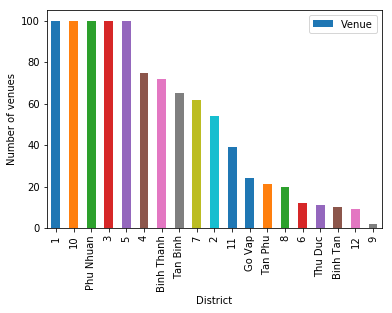

In [19]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

#### The number of venues in each category.

In [20]:
most_venues = hcm_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Vietnamese Restaurant,133,133,133,133,133,133
Café,127,127,127,127,127,127
Coffee Shop,72,72,72,72,72,72
Seafood Restaurant,33,33,33,33,33,33
Asian Restaurant,29,29,29,29,29,29
Hotel,27,27,27,27,27,27
Chinese Restaurant,25,25,25,25,25,25
Vegetarian / Vegan Restaurant,21,21,21,21,21,21
Japanese Restaurant,20,20,20,20,20,20


#### The number of categories in each district

Text(0,0.5,'Number of categories')

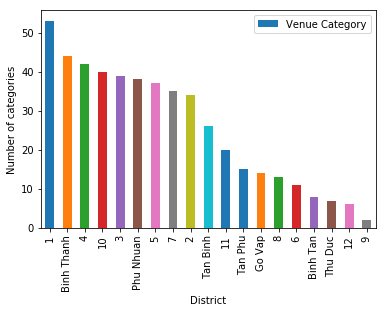

In [21]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

### Top 10 venue categories for each district

In [22]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,...,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wings Joint,Yoga Studio
0,1,0.000000,0.01,0.0,0.00,0.000000,0.0,0.000000,0.010000,0.030000,...,0.0,0.000000,0.020000,0.01,0.140000,0.0,0.000000,0.01,0.000000,0.0
1,10,0.000000,0.00,0.0,0.01,0.020000,0.0,0.010000,0.000000,0.000000,...,0.0,0.000000,0.020000,0.00,0.200000,0.0,0.000000,0.00,0.000000,0.0
2,11,0.025641,0.00,0.0,0.00,0.025641,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.025641,0.00,0.128205,0.0,0.025641,0.00,0.000000,0.0
3,12,0.000000,0.00,0.0,0.00,0.111111,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00,0.222222,0.0,0.000000,0.00,0.000000,0.0
4,2,0.000000,0.00,0.0,0.00,0.037037,0.0,0.055556,0.018519,0.018519,...,0.0,0.018519,0.000000,0.00,0.148148,0.0,0.000000,0.00,0.018519,0.0


In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,French Restaurant,Massage Studio,Bar,Clothing Store,Thai Restaurant,Middle Eastern Restaurant
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Seafood Restaurant,Spa,Ice Cream Shop,Music Venue,Market,Bookstore
2,11,Café,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Dumpling Restaurant,Cantonese Restaurant,American Restaurant,Gym / Fitness Center,French Restaurant
3,12,Café,Vietnamese Restaurant,Department Store,Diner,Seafood Restaurant,Asian Restaurant,Flower Shop,French Restaurant,Food Truck,Food Court
4,2,Vietnamese Restaurant,Café,BBQ Joint,Restaurant,Shopping Mall,Multiplex,Asian Restaurant,Coffee Shop,Thai Restaurant,Bistro
5,3,Vietnamese Restaurant,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Café,Hotel,Japanese Restaurant,Breakfast Spot,Yoga Studio,Restaurant
6,4,Vietnamese Restaurant,Seafood Restaurant,Coffee Shop,Snack Place,Café,Food,Hotel,Flea Market,Burger Joint,Bar
7,5,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Café,Dim Sum Restaurant,Dessert Shop,Noodle House,Asian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
8,6,Café,Department Store,Movie Theater,Fast Food Restaurant,Pizza Place,Coffee Shop,Food Court,Boutique,Dessert Shop,Asian Restaurant
9,7,Café,Vietnamese Restaurant,Japanese Restaurant,Gym / Fitness Center,Sushi Restaurant,Flea Market,Seafood Restaurant,Steakhouse,Restaurant,Spa


## Consider the data relating to category "café" only

In [24]:
hcm_grouped_cafe = hcm_grouped[["District", "Café"]]
hcm_grouped_cafe

,District,Café
0,1,0.080000
1,10,0.160000
2,11,0.179487
3,12,0.333333
4,2,0.111111
5,3,0.070000
6,4,0.040000
7,5,0.060000
8,6,0.166667
9,7,0.129032


We want to cluster districts by the category "Café" only. We will use the *K-Means clustering* to do this but first we need to determine how many k we need to use. The *"elbow" method* helps to find a good k.

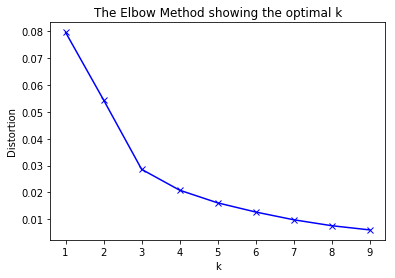

In [25]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

hcm_cafe_clustering = hcm_grouped_cafe.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_cafe_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_cafe_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_cafe_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We see that, the "elbow" appears at k=3.

In [26]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_cafe_clustering)

Let's create a new dataframe look like **hcm_grouped_cafe** but contains the cluster labels for each district.

In [27]:
df_cafe = hcm_grouped_cafe.copy()
df_cafe["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_cafe = df_cafe.join(df.set_index("District"), on="District")

# sort the table by cluster labels
df_cafe.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_cafe = df_cafe.drop(["Subdistrict", "Area (km2)"], axis=1)

# change to numeric date type
df_cafe['Average Housing Price (1M VND)'] = df_cafe['Average Housing Price (1M VND)'].astype(float)

df_cafe

,District,Café,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,0.080000,0,193632,25049.418,384.0,10.774540,106.699184
4,2,0.111111,0,147168,2958.745,58.8,10.791116,106.736729
5,3,0.070000,0,196333,39905.081,236.0,10.783529,106.687098
6,4,0.040000,0,186727,44671.531,70.3,10.759243,106.704890
7,5,0.060000,0,178615,41830.211,241.0,10.756129,106.670376
12,Binh Tan,0.100000,0,686474,13229.408,57.2,10.749809,106.605664
11,9,0.000000,0,290620,2549.298,41.2,10.824543,106.818015
10,8,0.050000,0,431969,22521.846,56.0,10.740400,106.665843
16,Tan Binh,0.153846,1,459029,20510.679,136.0,10.797979,106.653805
15,Phu Nhuan,0.210000,1,182477,37392.828,168.0,10.800118,106.677042


### Visualize the clusters on map

In [28]:
# create map
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the range of Average Housing Price (AHP)

#### Range of AHP

1. **Low** : $30 < AHP \le 100$.
2. **Medium** : $100 < AHP \le 200$.
2. **High** : $200 < AHP \le 300$.
2. **Very High** : $300 < AHP$.

In [29]:
count, division = np.histogram(df_cafe['Average Housing Price (1M VND)'], bins = [30, 100, 200, 300, 400])

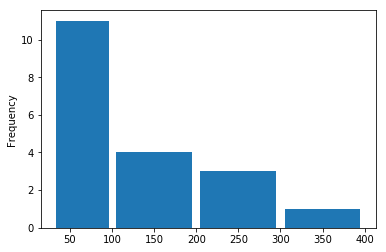

In [30]:
df_cafe['Average Housing Price (1M VND)'].plot.hist(bins=division, rwidth=0.9)

The number of districts in each range of AHP

In [31]:
count

array([11,  4,  3,  1], dtype=int64)

Now, we want to classify the AHP of each district into above types by creating a new columns whose name is "AHP Level". In order to do that, we need to create a function first.

In [32]:
def classify_ahp(price):
    if price <= 100:
        return "Low"
    elif price <= 200:
        return "Medium"
    elif price <= 300:
        return "High"
    else:
        return "Very High"

In [33]:
df_cafe["AHP Level"] = df_cafe["Average Housing Price (1M VND)"].apply(classify_ahp)
df_cafe

,District,Café,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude,AHP Level
0,1,0.080000,0,193632,25049.418,384.0,10.774540,106.699184,Very High
4,2,0.111111,0,147168,2958.745,58.8,10.791116,106.736729,Low
5,3,0.070000,0,196333,39905.081,236.0,10.783529,106.687098,High
6,4,0.040000,0,186727,44671.531,70.3,10.759243,106.704890,Low
7,5,0.060000,0,178615,41830.211,241.0,10.756129,106.670376,High
12,Binh Tan,0.100000,0,686474,13229.408,57.2,10.749809,106.605664,Low
11,9,0.000000,0,290620,2549.298,41.2,10.824543,106.818015,Low
10,8,0.050000,0,431969,22521.846,56.0,10.740400,106.665843,Low
16,Tan Binh,0.153846,1,459029,20510.679,136.0,10.797979,106.653805,Medium
15,Phu Nhuan,0.210000,1,182477,37392.828,168.0,10.800118,106.677042,Medium


We can understand the clusters

- **Cluster 0** : There are not many café shops in these districts.
- **Cluster 1** : There are a lot of café shops in these districts.
- **Cluster 2** : The number of café shops in these districts is medium.

### Choropleth map of AHP

Now we want to create a choropleth map of AHP coupling with the map of clusters created in previous section.

In [34]:
hcm_geo = r'hcm_urban.geojson' # geojson file

map_ahp = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

map_ahp.choropleth(
 geo_data=hcm_geo,
 name='choropleth',
 data=df_cafe,
 columns=['District', 'Average Housing Price (1M VND)'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Housing Price'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ahp)

map_ahp

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Choropleth map of population density



In [35]:
map_density = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

map_density.choropleth(
 geo_data=hcm_geo,
 name='choropleth',
 data=df_cafe,
 columns=['District', 'Density (pop/m2)'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Population density'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_density)

map_density

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Conclusion

From all above results, we conclude that, the best place for us to set up a new café is in **district 4** because there are a lot of people living there (high density), there are not many already-working café (cluster 0) and the average housing price is low.